# Notebook setup

In [1]:
MISSING = """Please install `bw2analyzer` in this environment:

conda install -c conda-forge -c cmutel bw2analyzer
"""

try:
    import bw2analyzer as ba
except ImportError:
    raise ImportError(MISSING)

In [2]:
import bw2analyzer as ba

UPDATE = """Please install the latest version of `bw2analyzer` in this environment:

conda upgrade -c conda-forge -c cmutel bw2analyzer
"""

if ba.__version__ < (0, 11):
    raise ImportError(UPDATE)

In [14]:
import bw2data as bd
import bw2calc as bc
import numpy as np

In [ ]:
bd.set_project("something with ecoinvent")

In [4]:
ei = bd.Database("ecoinvent 3.8 cutoff")

# Contribution analysis

Before we dive in to `bw2analyzer`, we can actually do the basic contribution analysis easily by ourselves. All we need is to sum one axis of the `lca.characterized_inventory` matrix, sort the values and indices, and then retrieve the metadata for the indices with the highest values.

In [43]:
our_act = ei.random()
our_fu = {our_act: 1}

In [44]:
lca = bc.LCA(our_fu, ('IPCC 2013', 'climate change', 'GWP 100a'))
lca.lci()
lca.lcia()
lca.score

7.069423757267165

Let's look at activities. In this case, we need to sum the rows (stressors or biosphere flows), which are the first axis. As Python is 0-indexed, we use `axis=0`:

In [45]:
lca.characterized_inventory.shape

(2171, 19565)

In [46]:
by_activity = np.array(lca.characterized_inventory.sum(axis=0))
by_activity.shape

(1, 19565)

We then need to sort the values. As some may be large, but negative, we sort by the absolute value.

There are tricks to do this very quickly in numpy, but we can also be simple:

In [47]:
sorted_values = sorted([(abs(value), value, index) for index, value in enumerate(by_activity[0, :])], reverse=True)

In [48]:
sorted_values[:5]

[(0.904846176367025, 0.904846176367025, 13098),
 (0.788165020056428, 0.788165020056428, 19206),
 (0.6872529326491473, 0.6872529326491473, 15354),
 (0.5030318274158977, 0.5030318274158977, 2485),
 (0.4147596711809174, 0.4147596711809174, 13173)]

Then we need to relate these **matrix** indices to something useful. We do this by going backwards, not from database IDs to matrix indices, but matrix indices to database IDs:

In [49]:
for _, value, index in sorted_values[:5]:
    print(value, bd.get_activity(lca.dicts.activity.reversed[index]))

0.904846176367025 'ammonia production, steam reforming, liquid' (kilogram, RER w/o RU, None)
0.788165020056428 'ammonia production, steam reforming, liquid' (kilogram, RU, None)
0.6872529326491473 'heat production, natural gas, at industrial furnace >100kW' (megajoule, Europe without Switzerland, None)
0.5030318274158977 'heat production, natural gas, at boiler modulating >100kW' (megajoule, RoW, None)
0.4147596711809174 'heat production, natural gas, at boiler modulating >100kW' (megajoule, Europe without Switzerland, None)


We can also get this information with `bw2analyzer`:

In [50]:
ba.ContributionAnalysis().annotated_top_processes(lca)[:5]

[(0.904846176367025,
  0.6437014354414904,
  'ammonia production, steam reforming, liquid' (kilogram, RER w/o RU, None)),
 (0.788165020056428,
  0.5473367977344202,
  'ammonia production, steam reforming, liquid' (kilogram, RU, None)),
 (0.6872529326491473,
  11.639132357240065,
  'heat production, natural gas, at industrial furnace >100kW' (megajoule, Europe without Switzerland, None)),
 (0.5030318274158977,
  8.593098641551938,
  'heat production, natural gas, at boiler modulating >100kW' (megajoule, RoW, None)),
 (0.4147596711809174,
  7.085179451376066,
  'heat production, natural gas, at boiler modulating >100kW' (megajoule, Europe without Switzerland, None))]

The returned format here is `(LCIA score, amount in supply array, activity metadata)`.

Similary, we can look at the emissions:

In [51]:
ba.ContributionAnalysis().annotated_top_emissions(lca)[:5]

[(4.143836269785185,
  4.143836269785181,
  'Carbon dioxide, fossil' (kilogram, None, ('air', 'urban air close to ground'))),
 (1.3710796581065912,
  1.3710796581065874,
  'Carbon dioxide, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks'))),
 (0.7958003121622452,
  0.7958003121622444,
  'Carbon dioxide, fossil' (kilogram, None, ('air',))),
 (0.3384182538839878,
  0.011394553710122327,
  'Methane, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks'))),
 (0.2842234218061411,
  0.0010733513402891783,
  'Dinitrogen monoxide' (kilogram, None, ('air', 'urban air close to ground')))]

# Miscellaneous functions

## Graphing the technosphere matrix

In [37]:
from bw2analyzer.matrix_grapher import SparseMatrixGrapher 

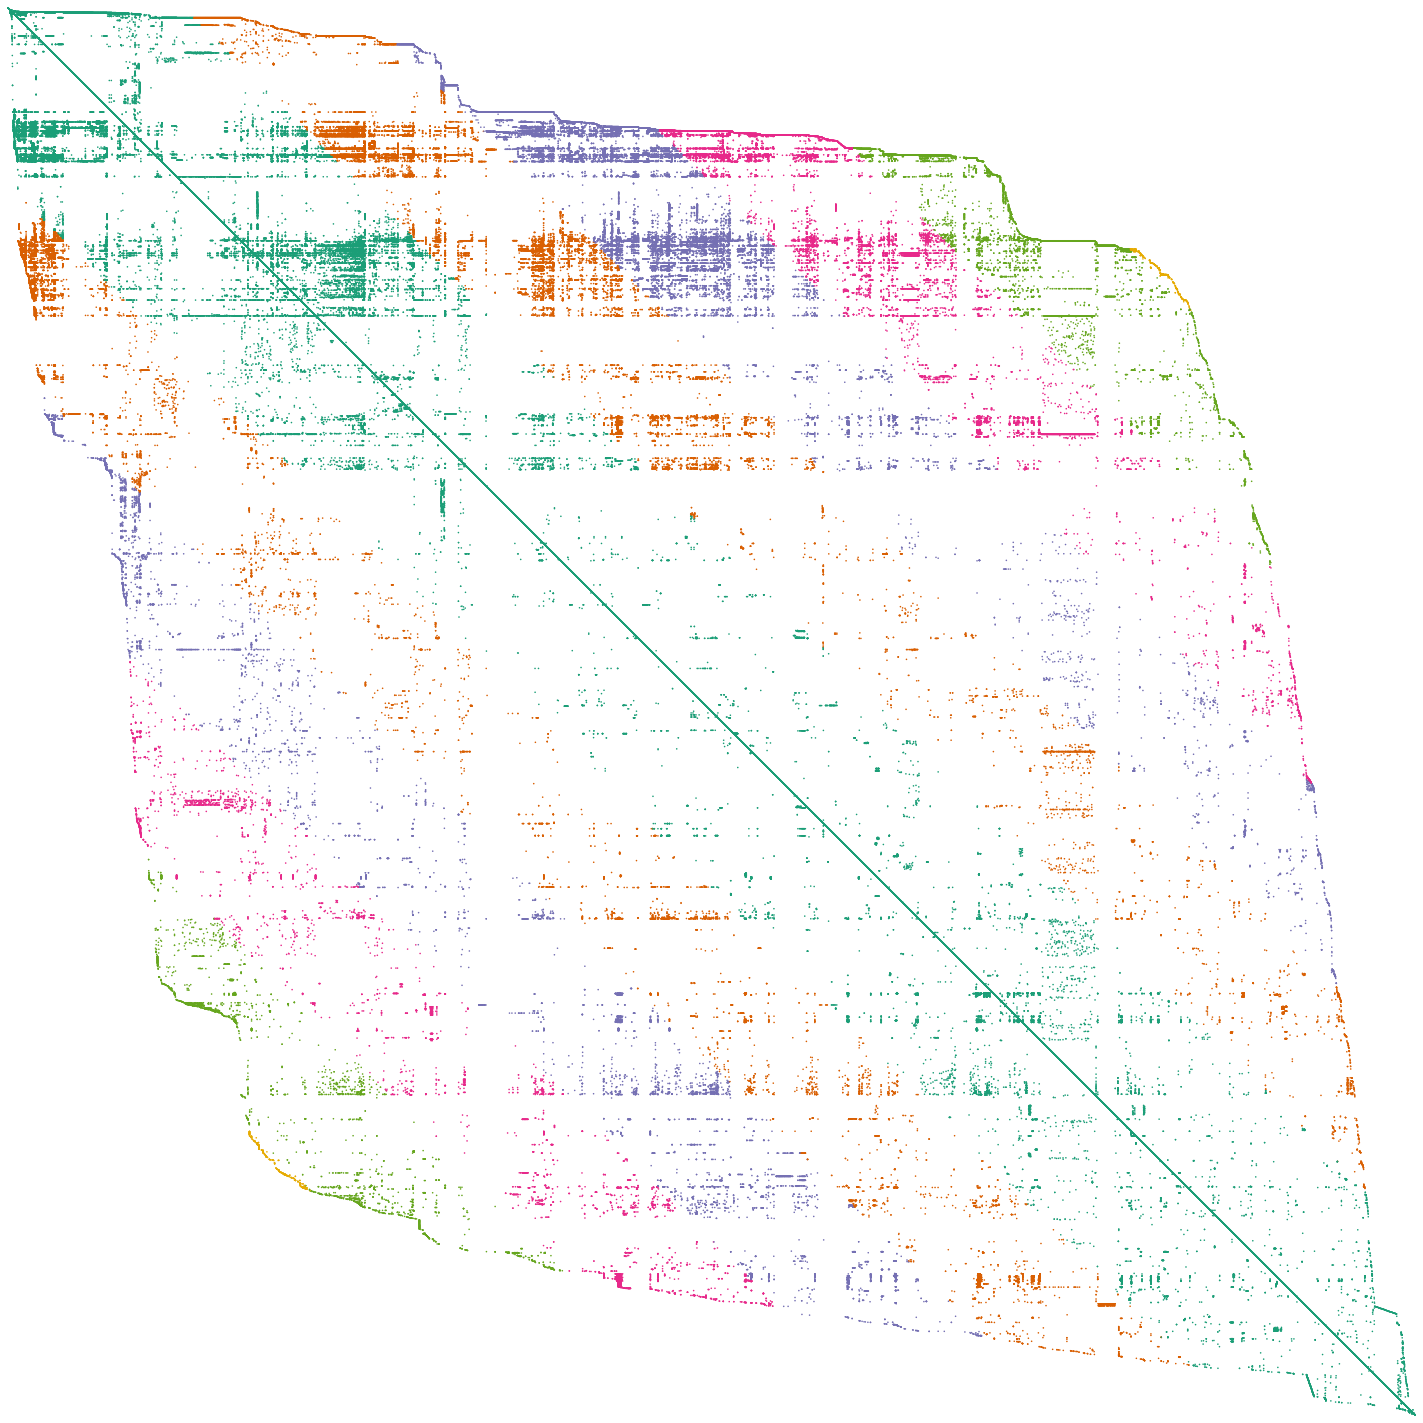

In [38]:
smg = SparseMatrixGrapher(lca.technosphere_matrix).ordered_graph()

## Economic analysis

Do the rich activities have all the impact in this world?

In [52]:
from bw2analyzer.econ import gini_coefficient, herfindahl_index, concentration_ratio, theil_index

In [53]:
income = lca.characterized_inventory.data

In [54]:
gini_coefficient(income), herfindahl_index(income), concentration_ratio(income), theil_index(income)

(0.9943317639286813, 0.05192789287590907, 0.407440778781071, 5.611374279776615)

# Traversing the supply chain

There is an industrial-strength class in `bw2calc` called `GraphTraversal`, but for quick analysis we can use the following:

In [57]:
ba.print_recursive_supply_chain(our_act)

1: 'market for inorganic nitrogen fertiliser, as N' (kilogram, IS, None)
  0.708: 'nutrient supply from NPK (15-15-15) fertiliser' (kilogram, RER, None)
    4.72: 'market for NPK (15-15-15) fertiliser' (kilogram, RER, None)
  0.146: 'nutrient supply from ammonium nitrate phosphate' (kilogram, RER, None
    0.663: 'market for ammonium nitrate phosphate' (kilogram, RER, None)
  0.146: 'nutrient supply from diammonium phosphate' (kilogram, RER, None)
    0.81: 'market for diammonium phosphate' (kilogram, RER, None)


In the above function, you can play with the following default arguments:

* amount=1,
* max_level=2,
* cutoff=0,
* file_obj=None,
* tab_character="  ",
* level=0,

Similarly, we can traverse the *characterized* inventory.

In [58]:
ba.print_recursive_calculation(our_act, ('IPCC 2013', 'climate change', 'GWP 100a'))

Fraction of score | Absolute score | Amount | Activity
0001 | 7.069 |     1 | 'market for inorganic nitrogen fertiliser, as N' (kilogram, IS, None)
  0.691 | 4.888 | 0.7083 | 'nutrient supply from NPK (15-15-15) fertiliser' (kilogram, RER, None)
    0.691 | 4.888 | 4.722 | 'market for NPK (15-15-15) fertiliser' (kilogram, RER, None)
      0.015 | 0.1061 | 0.8089 | 'market for transport, freight, lorry, unspecified' (ton kilometer, RE
      0.674 | 4.768 | 4.722 | 'NPK (15-15-15) fertiliser production' (kilogram, RER, None)
  0.142 | 1.007 | 0.1458 | 'nutrient supply from ammonium nitrate phosphate' (kilogram, RER, None
    0.142 | 1.007 | 0.6629 | 'market for ammonium nitrate phosphate' (kilogram, RER, None)
      0.14 | 0.9897 | 0.6629 | 'ammonium nitrate phosphate production' (kilogram, RER, None)
  0.166 | 1.175 | 0.1458 | 'nutrient supply from diammonium phosphate' (kilogram, RER, None)
    0.166 | 1.175 | 0.8102 | 'market for diammonium phosphate' (kilogram, RER, None)
      0.163